In [ ]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import os
import seaborn as sns
import re
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import recall_score
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [ ]:
# Connect to google drive
in_colab = False

try:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir("/content/drive/My Drive/Capstone/Project_2")
    in_colab = True
except:
    pass

Mounted at /content/drive


In [ ]:
def load_data(filepath):
    '''
    load one-hot encoded data prepared in the exploratory data analysis script.
    '''
    df = pd.read_excel(filepath)

    # copy to maintain original information - unscaled
    df_copy = df.copy()
    df = df.drop(["Unnamed: 0", 'pdays'], axis=1, errors='ignore')
    
    return df, df_copy

df, df_copy = load_data('Data/one_hot.xlsx')
df.head()

,age,duration,campaign,previous,empvarrate,conspriceidx,consconfidx,euribor3m,nremployed,y,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,261,1,0,1.1,93.994,-36.4,4.857,5191.0,no,...,0,0,0,1,0,0,0,0,1,0
1,57,149,1,0,1.1,93.994,-36.4,4.857,5191.0,no,...,0,0,0,1,0,0,0,0,1,0
2,37,226,1,0,1.1,93.994,-36.4,4.857,5191.0,no,...,0,0,0,1,0,0,0,0,1,0
3,40,151,1,0,1.1,93.994,-36.4,4.857,5191.0,no,...,0,0,0,1,0,0,0,0,1,0
4,56,307,1,0,1.1,93.994,-36.4,4.857,5191.0,no,...,0,0,0,1,0,0,0,0,1,0


### Prepare Data for Modeling

In [ ]:
# separate features from labels
X = df.drop('y', axis=1)
y = df['y']

# separate training data and non-training data - stratify to maintain ratio
# of imbalanced labels
X_train, X_remain, y_train, y_remain = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y)

# split non-training data into validation and test sets - stratify to maintain 
# ratio of imbalanced labels
X_valid, X_test, y_valid, y_test = train_test_split(
    X_remain, y_remain, test_size=0.50, random_state=42, stratify=y_remain)

In [ ]:
# Scale the numeric data to have mean 0 standard deviation 1

cols_to_scale = ['age', 'duration', 'empvarrate', 'conspriceidx', 'consconfidx', 'euribor3m', 'nremployed']

scaler = StandardScaler()

# fit and transform training data
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])

# transform validation and test data
X_valid[cols_to_scale] = scaler.transform(X_valid[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

In [ ]:
X_train.head()

,age,duration,campaign,previous,empvarrate,conspriceidx,consconfidx,euribor3m,nremployed,year,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
7309,0.961016,-0.408114,2,0,0.648136,0.722717,0.887472,0.714873,0.332204,2008,...,0,0,0,0,1,0,0,0,1,0
4169,1.057229,-0.384959,5,0,0.648136,0.722717,0.887472,0.713720,0.332204,2008,...,0,0,0,1,0,0,0,0,1,0
35810,0.576165,-0.168849,2,0,-1.198744,-1.181025,-1.231784,-1.368338,-0.935879,2009,...,0,0,0,1,0,0,0,0,1,0
9668,0.576165,-0.902081,1,0,0.839193,1.537124,-0.280281,0.773060,0.844128,2008,...,0,0,0,1,0,0,0,0,1,0
34389,-1.444302,1.498288,5,0,-1.198744,-1.181025,-1.231784,-1.355664,-0.935879,2009,...,0,0,0,0,1,0,0,0,1,0


In [ ]:
# investigate value counts for each training set - verify stratification done
# correctly
y_train.value_counts()
y_valid.value_counts()
y_test.value_counts()

no     25583
yes     3248
Name: y, dtype: int64

### Logistic Regression - Out of Box

In [ ]:
# intialize logistic regression model with sklearn
clf = LogisticRegression(random_state=0, solver='newton-cholesky', max_iter=5000).fit(X_train, y_train)

In [ ]:
# make predictions
valid_predictions = clf.predict(X_valid)
valid_predictions

array(['no', 'no', 'yes', ..., 'no', 'no', 'no'], dtype=object)

In [ ]:
def print_accuracy(model, features, y_true):
    # calculate accuracy of predictions

    acc_score = model.score(features, y_true)
    print(f"Model Accuracy: {np.round(acc_score, 3)}")


def print_metrics(y_true, y_preds):
    ## calculate and print the classification metrics for model evaluation

    # precision scores
    precision_mac = precision_score(y_true, y_preds, average='macro')
    precision_mic = precision_score(y_true, y_preds, average='micro')
    precision_weighted = precision_score(y_true, y_preds, average='weighted')

    print(f"Macro Precision: {np.round(precision_mac, 3)}")
    print(f"Micro Precision: {np.round(precision_mic, 3)}")
    print(f"Weighted Precision: {np.round(precision_weighted, 3)}")

    # recall scores
    recall_mac = recall_score(y_true, y_preds, average='macro')
    recall_mic = recall_score(y_true, y_preds, average='micro')
    recall_weighted = recall_score(y_true, y_preds, average='weighted')

    print(f"Macro Recall: {np.round(recall_mac, 3)}")
    print(f"Micro Recall: {np.round(recall_mic, 3)}")
    print(f"Weighted Recall: {np.round(recall_weighted, 3)}")

    # f1 scores
    f1_mac = f1_score(y_true, y_preds, average='macro')
    f1_mic = f1_score(y_true, y_preds, average='micro')
    f1_weighted = f1_score(y_true, y_preds, average='weighted')

    print(f"Macro f1: {np.round(f1_mac, 3)}")
    print(f"Micro f1: {np.round(f1_mic, 3)}")
    print(f"Weighted f1: {np.round(f1_weighted, 3)}")

In [ ]:
print_accuracy(clf, X_valid, y_valid)

Model Accuracy: 0.912


In [ ]:
print_metrics(y_valid, valid_predictions)

Macro Recall: 0.692
Micro Recall: 0.912
Weighted Recall: 0.912


### ROC AUC

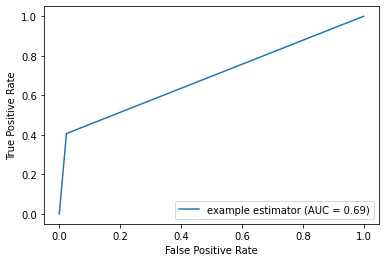

In [ ]:
### Change 'yes' 'no' to 1, 0
valid_binary = list(y_valid.replace("no", 0).replace("yes", 1))
valid_binary_preds = list(pd.Series(valid_predictions).replace("no", 0).replace("yes", 1))

# sklearn function to display ROC curve
fpr, tpr, thresholds = metrics.roc_curve(valid_binary, valid_binary_preds)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()
plt.show()

### Confusion Matrix

In [ ]:
cm = metrics.confusion_matrix(y_valid, valid_predictions)
# print(cm)

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions


def show_confusion_matrix(y_true, y_preds):
    # function to display confusion matrix image with sklearn library
    # confusion matrix with raw numbers and normalized values are shown

    binary_true = list(y_true.replace("no", 0).replace("yes", 1))
    binary_preds = list(pd.Series(y_preds).replace("no", 0).replace("yes", 1))

    ConfusionMatrixDisplay.from_predictions(
    binary_true, binary_preds)

    plt.xticks(ticks = [0, 1], labels = ['No', 'Yes'])
    plt.yticks(ticks = [0, 1], labels = ['No', 'Yes'])

    plt.title("Confusion Matrix")
    plt.show()

    print("\n---------------------------------------\n")

    ConfusionMatrixDisplay.from_predictions(
    binary_true, binary_preds, normalize='true')

    plt.xticks(ticks = [0, 1], labels = ['No', 'Yes'])
    plt.yticks(ticks = [0, 1], labels = ['No', 'Yes'])

    plt.title("Confusion Matrix")
    plt.show()

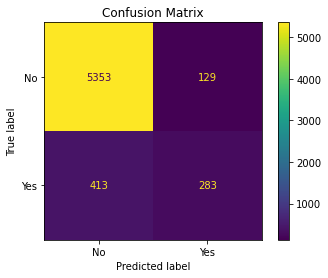


---------------------------------------



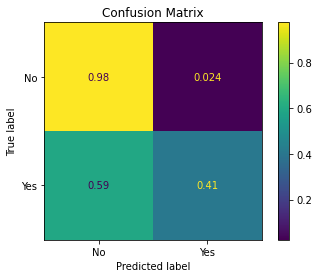

In [ ]:
show_confusion_matrix(y_valid, valid_predictions)

### Logistic Regression - Hyperparameter Tuning

In [ ]:
param_grid = [    
    {'penalty' : ['l1','l2','none'],
    'C' : np.logspace(-4, 4, 3),
    'solver' : ['lbfgs','liblinear'],
    }
]

In [ ]:
logModel = LogisticRegression()
# print(logModel.get_params().keys())
clf = GridSearchCV(logModel, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)

In [ ]:
# Fitting the best model
best_clf = clf.fit(X,y)

In [ ]:
# Finding the best estimator
best_clf.best_estimator_

In [ ]:
print (f'Accuracy - : {best_clf.score(X,y):.3f}')

In [ ]:
valid_predictions = best_clf.predict(X_valid)
print_metrics(y_valid, valid_predictions)

## Support Vector Classifier - Out of Box

In [ ]:
model = SVC()
model.fit(X_train, y_train)

svc_valid_preds = model.predict(X_valid)

[INFO] training our support vector regression model


In [ ]:
print_metrics(y_valid, svc_valid_preds)

Macro Recall: 0.5
Micro Recall: 0.887
Weighted Recall: 0.887


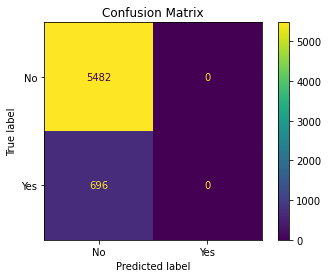


---------------------------------------



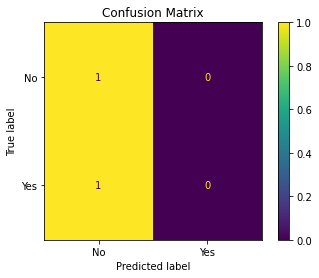

In [ ]:
show_confusion_matrix(y_valid, svc_valid_preds)

### Hyperparameter Tuning



In [ ]:
param_grid = { 'C':[0.1,1,10],'kernel':['rbf','sigmoid','linear'],'degree':[2,3,4]}
grid = GridSearchCV(SVC(),param_grid)

In [ ]:
grid.fit(X_train,y_train)

## Random Forest - Out of Box

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)

rf_preds = rf_clf.predict(X_valid)

In [ ]:
print_metrics(y_valid, rf_preds)

Macro Precision: 0.81
Micro Precision: 0.915
Weighted Precision: 0.905


In [ ]:
print_accuracy(rf_clf, X_valid, y_valid)

Model Accuracy: 0.915


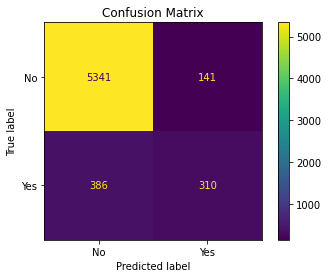


---------------------------------------



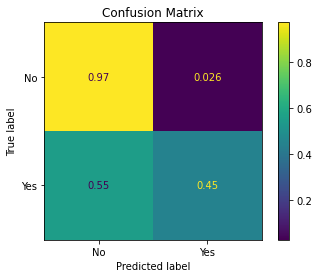

In [ ]:
show_confusion_matrix(y_valid, rf_preds)

In [ ]:
# match the features to their calculated importance from the random forest
cols_and_scores = list(zip(X_train.columns, rf_clf.feature_importances_))
cols_and_scores.sort(key = lambda x: x[1], reverse=True)
cols_and_scores[:5]

[('duration', 0.28038623970320903),
 ('euribor3m', 0.09995379529108474),
 ('age', 0.07831170951729077),
 ('nremployed', 0.04852712216686068),
 ('campaign', 0.040344553104106874)]

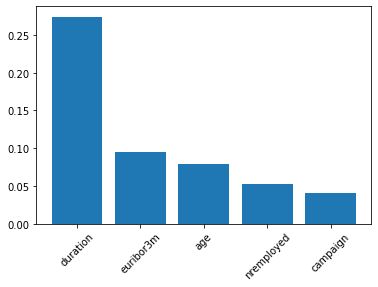

In [ ]:
def plot_feature_importance(cols_and_scores):
    # plot the feature importance for top 5 features from random forest model 
    plt.bar([i[0] for i in cols_and_scores][:5], [i[1] for i in cols_and_scores][:5])
    plt.xticks(rotation=45)
    plt.show()

plot_feature_importance(cols_and_scores)